In [40]:
import pandas as kunfu
import numpy as dragon
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter
import re

#importing packages for the prediction of time-series data
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error

In [41]:
train = kunfu.read_csv('C:\\Users\\Ayushi Asthana\\Documents\\MINOR 2\\bitcoin-price-prediction-lightweight-csv\\bitcoin_price_Training - Training.csv',parse_dates=['Date']).fillna(0)
print(train.head())


        Date     Open     High      Low    Close         Volume  \
0 2017-07-31  2763.24  2889.62  2720.61  2875.34    860,575,000   
1 2017-07-30  2724.39  2758.53  2644.85  2757.18    705,943,000   
2 2017-07-29  2807.02  2808.76  2692.80  2726.45    803,746,000   
3 2017-07-28  2679.73  2897.45  2679.73  2809.01  1,380,100,000   
4 2017-07-27  2538.71  2693.32  2529.34  2671.78    789,104,000   

       Market Cap  
0  45,535,800,000  
1  44,890,700,000  
2  46,246,700,000  
3  44,144,400,000  
4  41,816,500,000  


In [118]:
data = train['Close']
Date1 = train['Date']

In [42]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 7 columns):
Date          1556 non-null datetime64[ns]
Open          1556 non-null float64
High          1556 non-null float64
Low           1556 non-null float64
Close         1556 non-null float64
Volume        1556 non-null object
Market Cap    1556 non-null object
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 85.2+ KB
None


In [43]:
train1 = train[['Date','Close']]
train1.head()


,Date,Close
0,2017-07-31,2875.34
1,2017-07-30,2757.18
2,2017-07-29,2726.45
3,2017-07-28,2809.01
4,2017-07-27,2671.78


In [44]:
# Setting the Date as Index
train2 = train1.set_index('Date')
train2.sort_index(inplace=True)
print (type(train2))
print (train2.head())


<class 'pandas.core.frame.DataFrame'>
             Close
Date              
2013-04-28  134.21
2013-04-29  144.54
2013-04-30  139.00
2013-05-01  116.99
2013-05-02  105.21


In [45]:
plot.plot(train2)
plot.xlabel('Date', fontsize=12)
plot.ylabel('Price in USD', fontsize=12)
plot.title("Closing price distribution of bitcoin", fontsize=15)


Text(0.5,1,'Closing price distribution of bitcoin')

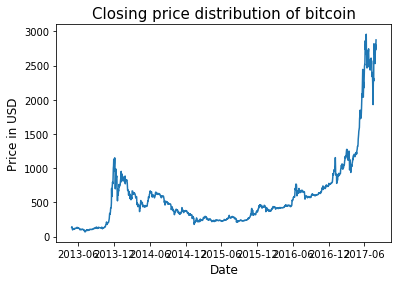

In [46]:
plot.show()

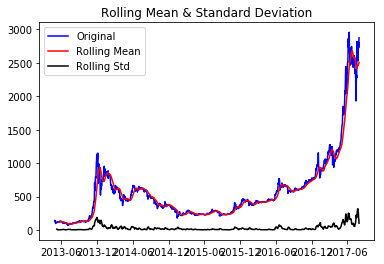

ADF Stastistic: 2.535589
p-value: 0.999060
The graph is non stationery
Critical values:
	1%: -3.435 
	5%: -2.863 
	10%: -2.568 


In [133]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(x):


    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    orig = plot.plot(x, color='blue',label='Original')
    mean = plot.plot(rolmean, color='red', label='Rolling Mean')
    std = plot.plot(rolstd, color='black', label = 'Rolling Std')
    plot.legend(loc='best')
    plot.title('Rolling Mean & Standard Deviation')
    plot.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))
        
ts = train2['Close']      
test_stationarity(ts)


# Making time series stationary

# Taking log transformation

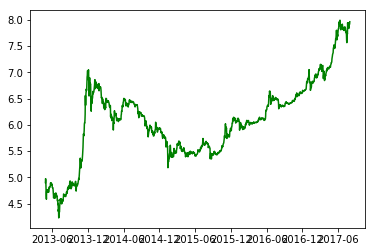

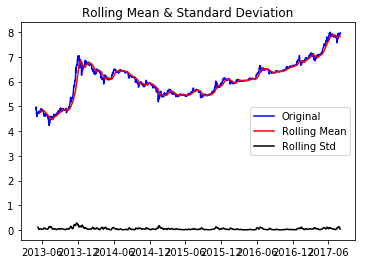

ADF Stastistic: -0.790465
p-value: 0.821907
The graph is non stationery
Critical values:
	1%: -3.435 
	5%: -2.863 
	10%: -2.568 


In [135]:
ts_log = dragon.log(ts)
plot.plot(ts_log,color="green")
plot.show()

test_stationarity(ts_log)

# Remove trend and seasonality with decomposition

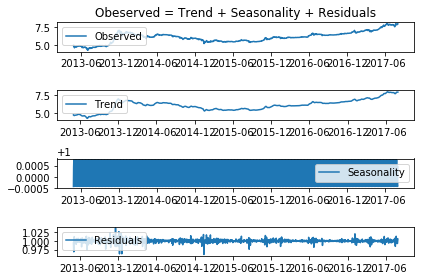

In [138]:
# Naive decomposition of our Time Series as explained above
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative',freq = 7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plot.subplot(411)
plot.title('Obeserved = Trend + Seasonality + Residuals')
plot.plot(ts_log,label='Observed')
plot.legend(loc='best')
plot.subplot(412)
plot.plot(trend, label='Trend')
plot.legend(loc='best')
plot.subplot(413)
plot.plot(seasonal,label='Seasonality')
plot.legend(loc='best')
plot.subplot(414)
plot.plot(residual, label='Residuals')
plot.legend(loc='best')
plot.tight_layout()
plot.show()

In [139]:
ts_log_decompose = residual
#ts_log_decompose.fillna(inplace=True)
#test_stationarity(ts_log_decompose)

# Remove trend and seasonality with differencing

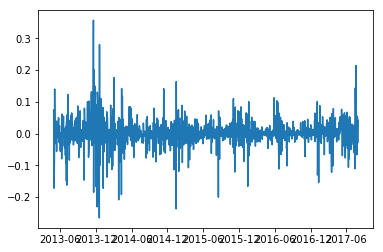

In [141]:
ts_log_diff = ts_log - ts_log.shift()
plot.plot(ts_log_diff)
plot.show()

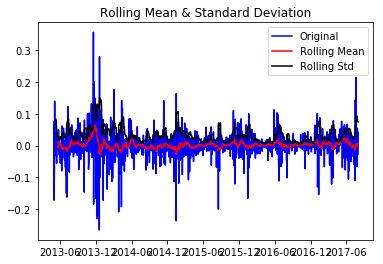

ADF Stastistic: -7.285034
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.435 
	5%: -2.863 
	10%: -2.568 


In [142]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)


# Plot the autocorreltaion and partial auto correlation functions

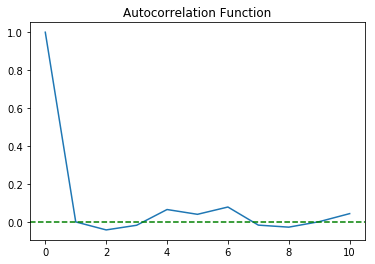

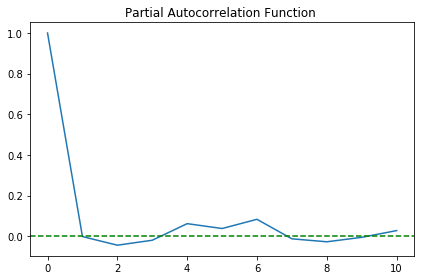

In [143]:
#ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

#Plot ACF: 
plot.subplot(1,1,1)

plot.plot(lag_acf)
#print(lag_acf[0.5])

plot.axhline(y=0,linestyle='--',color='g')
plot.title('Autocorrelation Function')
plot.show()

#Plot PACF:
plot.subplot(1,1,1)
plot.plot(lag_pacf)

plot.axhline(y=0,linestyle='--',color='green')
plot.title('Partial Autocorrelation Function ')
plot.tight_layout()
plot.show()


# AR MODEL

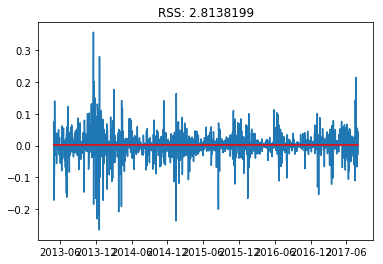

In [149]:
# follow lag
model = ARIMA(ts_log, order=(1,1,0))  
results_ARIMA = model.fit(disp=-1)  
plot.plot(ts_log_diff)
plot.plot(results_ARIMA.fittedvalues, color='red')
plot.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plot.show()

# Moving Average (MA) Model

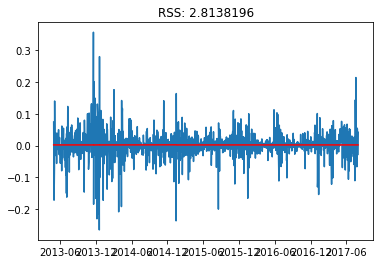

In [150]:
# follow error
model = ARIMA(ts_log, order=(0,1,1))  
results_MA = model.fit(disp=-1)  
plot.plot(ts_log_diff)
plot.plot(results_MA.fittedvalues, color='red')
plot.title('RSS: %.7f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
plot.show()

In [151]:
print(results_MA.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1555
Model:                 ARIMA(0, 1, 1)   Log Likelihood                2703.220
Method:                       css-mle   S.D. of innovations              0.043
Date:                Sun, 11 Mar 2018   AIC                          -5400.441
Time:                        13:08:13   BIC                          -5384.393
Sample:                    04-29-2013   HQIC                         -5394.473
                         - 07-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.001      1.829      0.068      -0.000       0.004
ma.L1.D.Close    -0.0012      0.027     -0.045      0.964      -0.053       0.051
                                    Root

# ARIMA MODEL

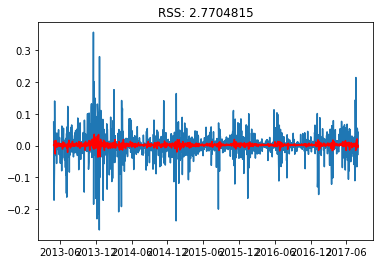

In [153]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(8,1,0))  
results_ARIMA = model.fit(disp=-1)  
plot.plot(ts_log_diff)
plot.plot(results_ARIMA.fittedvalues, color='red')
plot.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plot.show()

In [154]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1555
Model:                 ARIMA(8, 1, 0)   Log Likelihood                2715.504
Method:                       css-mle   S.D. of innovations              0.042
Date:                Sun, 11 Mar 2018   AIC                          -5411.009
Time:                        13:08:55   BIC                          -5357.516
Sample:                    04-29-2013   HQIC                         -5391.117
                         - 07-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.001      1.662      0.097      -0.000       0.004
ar.L1.D.Close    -0.0056      0.025     -0.221      0.826      -0.055       0.044
ar.L2.D.Close    -0.0432      0.025     

In [155]:
size = int(len(ts_log)-100)
train_arima, test_arima = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train_arima]
predictions = list()
originals = list()
error_list = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test_arima)):
    model = ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit(disp=-1)
    
    output = model_fit.forecast()
    
    pred_value = output[0]
    
        
    original_value = test_arima[t]
    history.append(original_value)
    
    pred_value = dragon.exp(pred_value)
    
    
    original_value = dragon.exp(original_value)
    
    
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    predictions.append(float(pred_value))
    originals.append(float(original_value))
    
    #error = mean_squared_error(dragon.exp(yhat), dragon.exp(obs))
    #print('mean_squared_error : ', error)
print('\n Means Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')


Printing Predicted vs Expected Values...


predicted = 1234.001727,   expected = 1207.210000,   error = 2.219310  %
predicted = 1208.696081,   expected = 1250.150000,   error = 3.315916  %
predicted = 1253.283975,   expected = 1265.490000,   error = 0.964530  %
predicted = 1265.426015,   expected = 1281.080000,   error = 1.221937  %
predicted = 1282.403188,   expected = 1317.730000,   error = 2.680884  %
predicted = 1319.094449,   expected = 1316.480000,   error = 0.198594  %
predicted = 1316.894868,   expected = 1321.790000,   error = 0.370341  %
predicted = 1324.010589,   expected = 1347.890000,   error = 1.771614  %
predicted = 1349.835125,   expected = 1421.600000,   error = 5.048176  %
predicted = 1422.645719,   expected = 1452.820000,   error = 2.076946  %
predicted = 1451.673011,   expected = 1490.090000,   error = 2.578166  %
predicted = 1491.152142,   expected = 1537.670000,   error = 3.025217  %
predicted = 1538.563599,   expected = 1555.450000,   error = 1.085628  %
predicte

C:\Users\Ayushi Asthana\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted = 2174.917811,   expected = 2286.410000,   error = 4.876299  %
predicted = 2294.967522,   expected = 2407.880000,   error = 4.689290  %
predicted = 2407.637129,   expected = 2488.550000,   error = 3.251406  %
predicted = 2488.088390,   expected = 2515.350000,   error = 1.083810  %
predicted = 2516.843441,   expected = 2511.810000,   error = 0.200391  %
predicted = 2515.695642,   expected = 2686.810000,   error = 6.368681  %
predicted = 2693.294229,   expected = 2863.200000,   error = 5.934122  %
predicted = 2861.584900,   expected = 2732.160000,   error = 4.737091  %
predicted = 2729.291482,   expected = 2805.620000,   error = 2.720558  %
predicted = 2817.831248,   expected = 2823.810000,   error = 0.211726  %
predicted = 2826.429525,   expected = 2947.710000,   error = 4.114396  %
predicted = 2953.661963,   expected = 2958.110000,   error = 0.150368  %
predicted = 2958.742032,   expected = 2659.630000,   error = 11.246378  %
predicted = 2663.574404,   expected = 2717.020000,

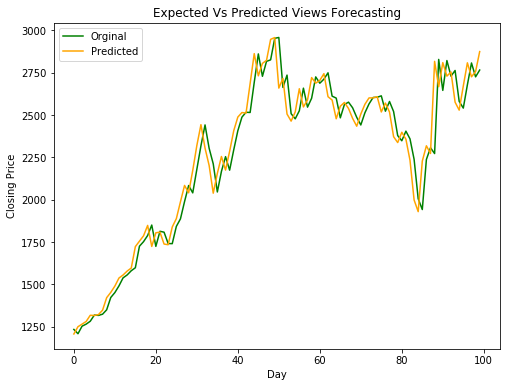

In [183]:
plot.figure(figsize=(8, 6))
test_day = [t
           for t in range(len(test_arima))]
labels={'Orginal','Predicted'}
plot.plot(test_day, predictions, color= 'green')
plot.plot(test_day, originals, color = 'orange')
plot.title('Expected Vs Predicted Views Forecasting')
plot.xlabel('Day')
plot.ylabel('Closing Price')
plot.legend(labels)
plot.show()